In [3]:
from collections import namedtuple
import numpy as np
from scipy import optimize


Leaf = namedtuple('Leaf', ('value'))
Node = namedtuple('Node', ('feature', 'value', 'impurity', 'left', 'right',))

class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth        
        self.features = x.shape[1]
        self.root = self.build_tree(self.x, self.y)
        
    def fit(self,x,y):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.features = x.shape[1]
        self.root = self.build_tree(self.x,self.y)
        return self
    
    def build_tree(self, x, y, depth=1):
        if self.criteria(y) < 1e-5:
            return Leaf(self.leaf_value(y))
        
        feature, value, impurity = self.find_best_split(x, y)
        
        left_xy, right_xy = self.partition(x, y, feature, value)
        left = self.build_tree(*left_xy, depth=depth + 1)
        right = self.build_tree(*right_xy, depth=depth + 1)
        
        return Node(feature, value, impurity, left, right)
    
    def leaf_value(self, y):
        raise NotImplementedError
    
    def partition(self, x, y, feature, value):
        i = x[:, feature] >= value
        j = np.logical_not(i)
        return (x[j], y[j]), (x[i], y[i])
    
    def _impurity_partition(self, value, feature, x, y):
        (_, left), (_, right) = self.partition(x, y, feature, value)
        return self.impurity(left, right)
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        for feature in range(self.features):
            if x.shape[0] > 2:
                x_interval = np.sort(x[:,feature])
                res = optimize.minimize_scalar(
                    self._impurity_partition, 
                    args=(feature, x, y),
                    bounds=(x_interval[1], x_interval[-1]),
                    method='Bounded',
                )
                #assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = np.max(x[:,feature])
                impurity = self._impurity_partition(value, feature, x, y)
            if impurity < best_impurity:
                best_feature, best_value, best_impurity = feature, value, impurity
        return best_feature, best_value, best_impurity
    
    def impurity(self, left, right):
        raise NotImplementedError

    def criteria(self, y):
        raise NotImplementedError
        
    def predict(self, x):
        x = np.atleast_2d(x)
        y = np.empty(x.shape[0], dtype=self.y.dtype)
        for i, row in enumerate(x):
            node = self.root
            while not isinstance(node, Leaf):
                if row[node.feature] >= node.value:
                    node = node.right
                else:
                    node = node.left
            y[i] = node.value
        return y

class DecisionTreeRegressor(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y, dtype=int)
        self.random_state = np.random.RandomState(random_state)
        super().__init__(x, y, *args, **kwargs)
        
    def impurity(self, left, right):
        h_l = self.criteria(left)
        h_r = self.criteria(right)
        return (left.size * h_l + right.size * h_r) / (left.size + right.size)

    def leaf_value(self, y):
        return np.mean(y)

    def criteria(self, y):
        return np.var(y)

In [4]:
from sklearn.model_selection import train_test_split

class RandomForestRegressor(DecisionTreeRegressor):
    def __init__(self, x, y , Ans = 1, rand = 1, *args, **kwargs):
        super().__init__(x, y, *args, **kwargs)
        self.trees = []
        self.rand = rand
        self.forest_size = Ans


    def fit(self, x, y):
        for i in range(self.forest_size):
            mask = np.random.random(y.shape[0])
            x_f, y_f = x[mask < self.rand], y[mask < self.rand] 
            regr = DecisionTreeRegressor(x_f, y_f, max_depth=self.max_depth)
            regr.fit(x_f, y_f)
            self.trees.append(regr)


    def predict(self, x):
        y_pred = np.zeros(x.shape[0], dtype=float)
        N = self.forest_size
        for tree in self.trees:
            y_pred += tree.predict(x)
        return y_pred/N

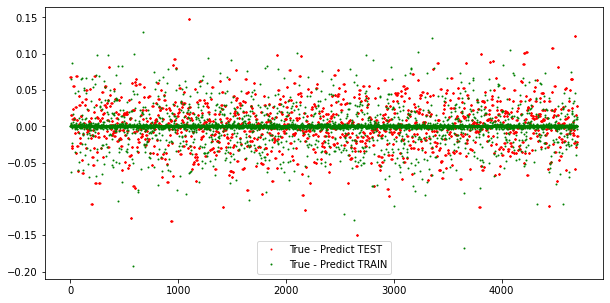

In [9]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import json
import csv

if __name__ == "__main__":
    data = pd.read_csv('sdss_redshift.csv')
    x = data.drop(columns = 'redshift').to_numpy()
    y = data['redshift'].to_numpy()
    x_tr, x_t, y_tr, y_t = train_test_split(x, y, train_size=0.8,
                        random_state=41, shuffle=True)
    regr = RandomForestRegressor(x_tr, y_tr, Ans = 1, rand = 0.7)
    regr.fit(x_tr, y_tr)
    y_p_t = regr.predict(x_t)
    y_p_tr = regr.predict(x_tr)

    err1 = mean_squared_error(y_tr, y_p_tr)
    err2 = mean_squared_error(y_t, y_p_t)
    
    
    plt.figure(figsize=(10,5))
    plt.plot(np.repeat(y_t - y_p_t, 4),'o' ,ms = 1,color='red', label='True - Predict TEST')
    plt.plot(y_tr - y_p_tr,'o' ,ms = 1,color='green', label='True - Predict TRAIN')
    plt.legend()
    plt.show()

    ans = {"train": err1,"test": err2}
    with open('redhsift.json', 'w') as f:
        json.dump(ans, f)

    df = pd.read_csv('sdss.csv')
    x = df.to_numpy()
    y_pred =regr.predict(x)
    df['redshift'] = y_pred

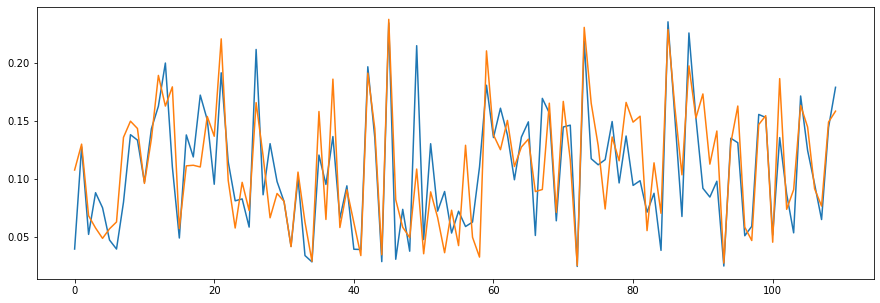

In [14]:
plt.figure(figsize=(15,5))
plt.plot(y_p_t[:110])
plt.plot(y_t[:110])
plt.show()
plt.show()

In [16]:
df.head(10)

,u,g,r,i,z,redshift
0,19.09193,17.86146,17.34277,16.99911,16.79246,0.108942
1,19.99864,17.97824,16.97658,16.52548,16.18047,0.107041
2,21.35460,19.08551,17.64716,17.13002,16.76863,0.212207
3,19.45749,17.71719,16.95912,16.60390,16.34567,0.071184
4,19.58866,17.98429,17.23228,16.85590,16.52430,0.072200
5,21.48726,19.09873,17.66684,17.10106,16.77120,0.227074
6,17.73339,16.71486,16.41702,16.21477,16.10830,0.051101
7,17.91927,16.68965,16.26973,15.97756,15.90915,0.015463
8,20.78510,18.67885,17.20493,16.64238,16.31031,0.228177
9,16.98516,15.77897,15.29237,15.02964,14.79433,0.024703
